In [2]:
from IPython.display import Image

# Détection des météores en utilisant mv-extractor

Ce notebook à pour but de montrer l'utilisation de mv-extractor (https://github.com/LukasBommes/mv-extractor.git) pour au final detecter des météores sur une vidéo

## 1 - Extraction et Affichage des vecteurs vitesses

Avec la commande ~$ extract_mvs vid_h264.mp4 --dump, cela lance l'extraction par défaut, nous pouvons afficher les vecteurs vitesses de chaque frame de la vidéo. De plus pour chaque image, il y a un fichier .npy associé avec la description des vecteurs.

-- dump permet de stocker les images avec les vecteurs vitesses.

Sinon, en se placant dans le dossier mv-extractor, on peut lancer la commande : ~$ python3 src/mvextractor/__main__.py vid_h264.mp4 --dump, qui lance notre propre fichier avec nos modifications.Par exemple, une image de Big Buck Bunny au format H264 : a

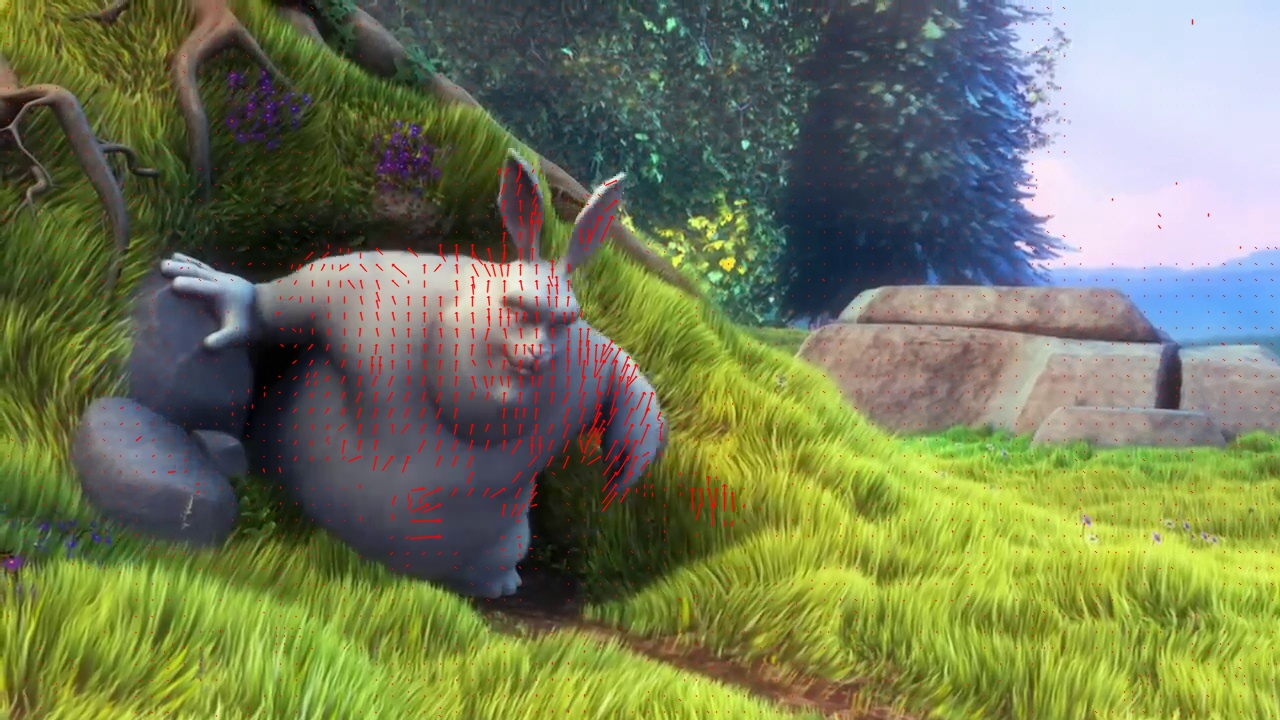

In [3]:
Image("BBB h264/frames/frame-33.jpg") 

Nous pouvons voir les vecteurs sur le lapin qui doit être en train de sortir de son terrier.

Aussi, de nombreux points rouges sont sur l'image, ce sont aussi des vecteurs vitesses mais avec une norme faible. Nous pourrons par la suite trouver une solution pour les supprimer et ainsi conserver uniquement les vecteurs "intéressant".

En plus de cette image, nous avons un fichier numpy associé. Pour l'extraire et le manipuler nous utilisons la bibliothèque pandas.

In [4]:
import numpy as np
import pandas as pd

# Charger un fichier .npy
data = np.load('BBB MPEG4/motion_vectors/mvs-33.npy')
pd.set_option('display.max_rows', None)
df = pd.DataFrame(data)

# Afficher le DataFrame
print(df)
print(data.dtype)

      0   1   2     3    4     5    6   7   8  9
0    -1  16  16     7    7     8    8  -3  -3  2
1    -1  16  16    23    7    24    8  -2  -2  2
2    -1  16  16    39    7    40    8  -2  -2  2
3    -1  16  16    55    7    56    8  -2  -2  2
4    -1  16  16    71    7    72    8  -2  -2  2
5    -1  16  16    88    8    88    8   0   0  2
6    -1  16  16   104    7   104    8  -1  -2  2
7    -1  16  16   119    7   120    8  -2  -2  2
8    -1  16  16   136    8   136    8  -1  -1  2
9    -1  16  16   151    7   152    8  -2  -2  2
10   -1  16  16   167    7   168    8  -2  -2  2
11   -1  16  16   183    7   184    8  -2  -2  2
12   -1  16  16   199    7   200    8  -2  -2  2
13   -1  16  16   215    7   216    8  -2  -2  2
14   -1  16  16   232    8   232    8   0   0  2
15   -1  16  16   248    8   248    8   0   0  2
16   -1  16  16   264    8   264    8   0   0  2
17   -1  16  16   280    7   280    8  -1  -3  2
18   -1  16  16   295    7   296    8  -2  -2  2
19   -1  16  16   31

/tmp/ipykernel_9397/3271666730.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Le tableau possède donc 10 colonnes et plus de 3000 lignes (le nombre de vecteurs vitesses).


#### Description des colonnes :
1. Colonne 0 : Désigne la frame de référence pour la frame actuelle, si <0 alors c'est une frame passé, si >0 alors frame future. Pour le moment on utilise uniquement les frames passés.
2. Colonne 3 : src_x : Coordonnées de x (en pixels) dans la frame de référence
3. Colonne 4 : src_y : Coordonnées de y (en pixels) dans la frame de référence
4. Colonne 5 : dst_x : Coordonnées de x (en pixels) dans la frame actuelle
5. Colonne 6 : dst_y : Coordonnées de y (en pixels) dans la frame actuelle
6. Colonne 7 : motion_x = motion_scale * (src_x - dst_x), longueur du vecteur en x
7. Colonne 8 : motion_y = motion_scale * (src_y - dst_y), longueur du vecteur en y
8. Colonne 9 : motion_scale : Utiliser pour transformer motion_x et motion_y en integer. Par exemple si motion_scale=4, les composantes motions peuvent être un int mais encode un float avec 1/4 pixel precision.

## 2 - Filtre sur les vecteurs
### 2.1 - Filtre sur la norme

Nous pouvons maintenant essayer d'afficher les vecteurs avec une norme suffisament importante, par exemple >10.

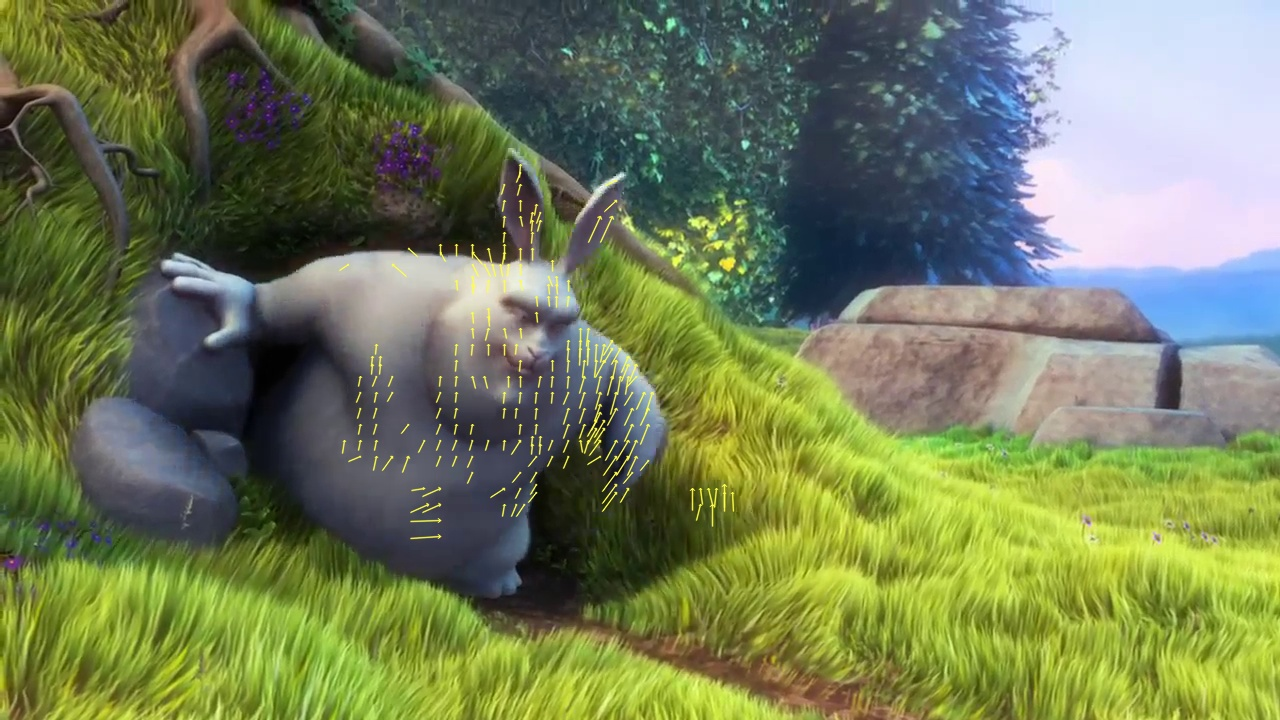

In [5]:
Image("BBB h264 norme>10/frames/frame-33.jpg")

Nous pouvons donc remarquer que tous les vecteurs qui ressemblaient plus à des "points" ont disparus. Choisir une norme supérieur à 10 pour cette frame est surement pas la meilleure solution, il serait plus intéressant de prendre une norme légérement inférieur pour essayer d'avoir le dessin du lapin en vecteur.

Une autre idée serait d'isoler des zones ou il y a de nombreux vecteurs vitesses pour détecter les météores ou autres objets en mouvements. Combiné au masque de la norme, nous pourrions obtenir des résultats intéressants.

Par la suite, un algorithme de type knapstack pourra être implementé. L'idée serait de maximiser une zone en faisant la somme des normes des vecteurs vitesses tout en minimisant le nombre de vecteurs utilisé. De plus, dans le cas des météores, nous pourrions ajouter une condition sur le sens et la direction des vecteurs. En effet, les météores ont un mouvement rectiligne, tous les vecteurs devront avoir le même sens et une direction assez similaire. 

### 2.2 Filtre sur la zone

Une autre idée serait de conserver uniquement les vecteurs qui possède des voisins assez proches et en nombre suffisants. Pour cela on peut utiliser le module,NearestNeighbors de python qui permet de trouver les voisins les plus proches. Ainsi,nous pouvons appliquer un filtre en conservant uniquement les vecteurs ayant un nombre minimum de voisins proches.
Tout d'abord on peut regarder une frame avec une météorite sans filtre :

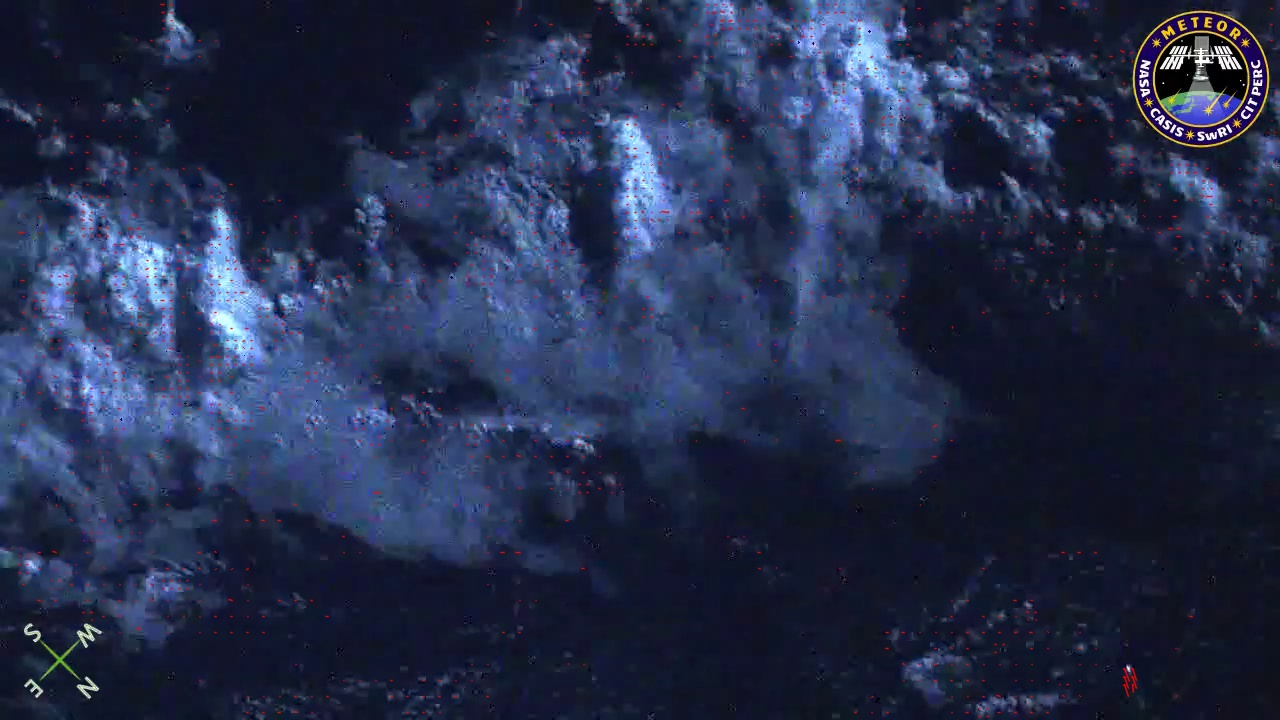

In [8]:
Image("mission Chiba sans filtre/frames/frame-102.jpg")

Nous pouvons donc remarquer de nombreux vecteurs "inutiles".
Maintenant en appliquant un filtre sur la norme et la zone en fixant une distance maximum de 16 et au minumum 3 voisins proches par exemple, nous obtenons :

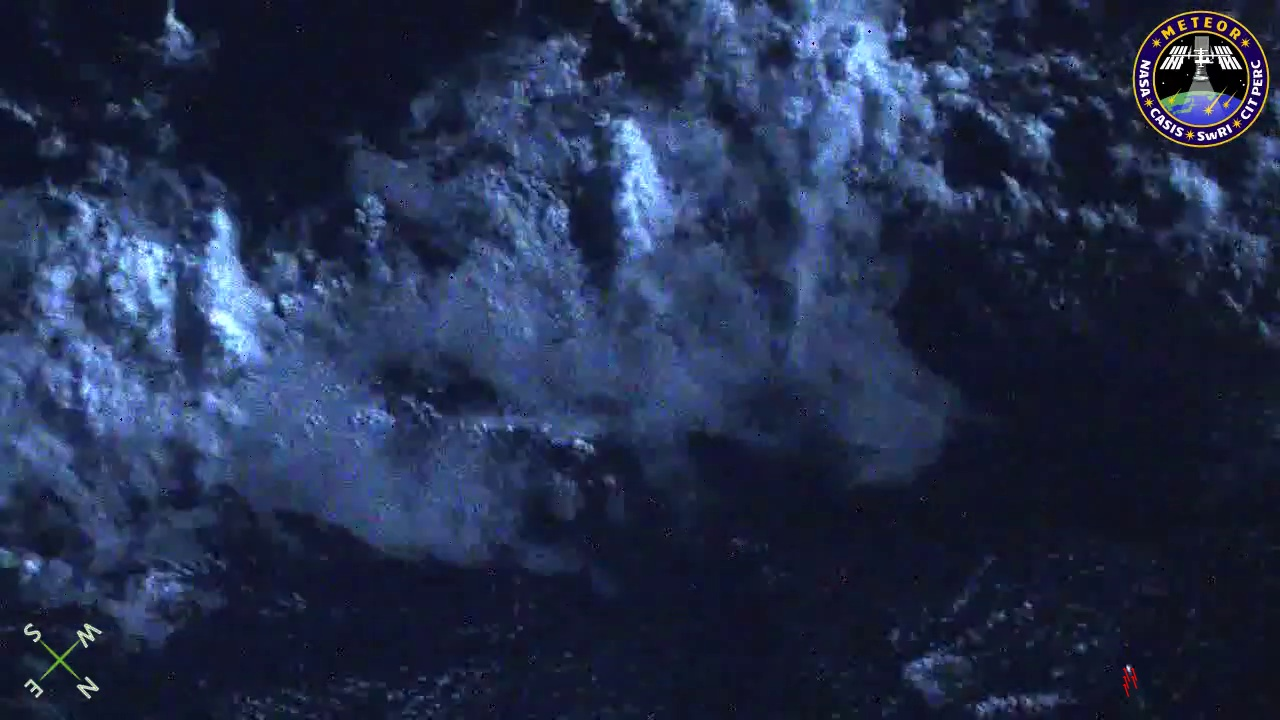

In [9]:
Image("Mission Chiba norme+zone/frames/frame-102.jpg")

Avec cette méthode nous arrivons à isoler le météore. 

Bien que nous ayons réussi à détecter le météore, cette méthode reste toujours imprécise car nous fixons les paramètres manuellement et n'est donc pas reproductibles.